In [1]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image
import joblib

%load_ext autoreload
%autoreload 1

2023-04-16 20:02:11.144887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%aimport visu.grad_cam

from visu.grad_cam import grad_cam_list


In [3]:
# for local use
storage_path = '../storage'

# input
input_path = os.path.join(storage_path, 'input')

data_name = 'data'
data_path = os.path.join(input_path, data_name)

model_name = 'model'
model_path = os.path.join(input_path, model_name)

# output
output_path = os.path.join(storage_path, 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

grad_cam_path = os.path.join(output_path, 'grad_cam')
if not os.path.exists(grad_cam_path):
    os.makedirs(grad_cam_path, exist_ok=True)

Model parameters

In [4]:
batch_size_cnn = 32
batch_size_transformer = 32

image_size = 256
input_shape = (image_size, image_size, 1)

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

label_smoothing = 0.1
lam_recon = 10.
patience = 5
min_delta = 0.005
min_delta_fine_tuning = 0.0005

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
patch_size = 1
transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier

In [5]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

In [6]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Flatten(),
    ],
    name='encoder'
)

In [7]:
classifier = keras.Sequential(
    [
      layers.Dense(1024, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(3, activation='softmax'),
    ],
    name='classifier'
)


In [8]:
# Sub Model
shared_encoder = keras.Sequential(name='shared_encoder')

for layer in encoder.layers[:-1]:
  shared_encoder.add(layer)

for layer in shared_encoder.layers:
  layer.trainable = False


In [9]:
%aimport myLayers.vision_transformer
%aimport myLayers.mlp
from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

inputs = layers.Input(shape=input_shape)
augmented_transformer = augmentation(inputs)
shared_encoded = shared_encoder(augmented_transformer)
features = add_vit(shared_encoded,
            patch_size=patch_size,
            input_image_size=shared_encoded.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model
model = keras.Model(inputs=inputs, outputs=softmax)
# shared_encoder.summary()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']     

In [26]:
model_type = "cnn"
model_type = "cnn_vit"

In [29]:
if model_type == "cnn_vit":
  model_name = 'mlops_cnn_vit_model_weights.hdf5'
  model_full_path = os.path.join(model_path, model_name)
  model.load_weights(model_full_path)
else:
  model_name = 'mlops_cnn_model.hdf5'
  model_full_path = os.path.join(model_path, model_name)
  model = keras.models.load_model(model_full_path)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']     

In [30]:
image_size = model.get_layer("input_1").get_output_at(0).shape[1]
input_shape = (image_size, image_size, 1)
input_shape

(256, 256, 1)

Def Grad-CAM model

In [31]:
if model_type == "cnn_vit":
  output_conv_layer = model.get_layer("shared_encoder").get_output_at(0)
  resize_shape = None
else:
  output_conv_layer = model.get_layer("conv2d_4").get_output_at(0)
  resize_shape = None


grad_model = keras.Model(
  [model.input],
  [output_conv_layer, model.output])

Text(0.5, 1.0, 'Hist equalize')

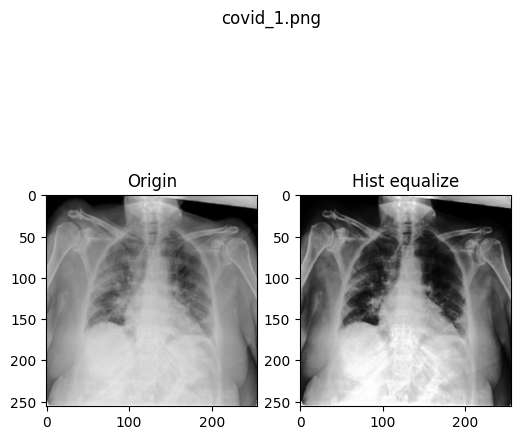

In [32]:
image_name = "covid_1.png"
# image_name = "covid_41.png"
# image_name = "covid_165.png"
image_full_file_name = os.path.join(data_path, image_name)

image = cv2.imread(image_full_file_name, 0)    
image_rect = cv2.equalizeHist(image)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
fig.suptitle(os.path.basename(image_name))
ax.flatten()[0].imshow(image, cmap='gray');
ax.flatten()[0].set_title('Origin')
ax.flatten()[1].imshow(image_rect, cmap='gray');
ax.flatten()[1].set_title('Hist equalize')


In [33]:
model.predict(np.array([image_rect]))

1/1 [==============================] - 0s 114ms/step


array([[0.0372303 , 0.924063  , 0.03870675]], dtype=float32)

Grad-CAM on single image

In [34]:
cam = grad_cam_list(
  [image_full_file_name], grad_model,
  image_size=image_size, resize_shape=resize_shape,
  pred_index=None
)[0]

(8, 8, 64)


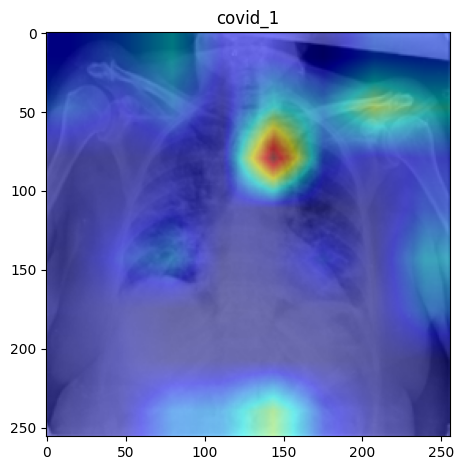

In [35]:
cam_RGB = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(cam_RGB)

fig, ax = plt.subplots()
ax.imshow(im_pil)
f_name = os.path.splitext(os.path.basename(image_full_file_name))[0]
ax.set_title(f_name)
fig.tight_layout()

plt.savefig(os.path.join(grad_cam_path, 'grad_cam_' + f_name + '.png'), format='png')
plt.show()